# Flopy Tutorial: Steady-State, Confined Aquifer 

This script will walk through the creation of a single-layer, confined aquifer in flopy and use MODFLOW-2005 to run a steady-state simulation of groundwater flow in a 100m x 100m domain with a 10m head boundary on one side and a 0m head boundary on the other side, as displayed below:

<img src="https://i.imgur.com/PH9sCDw.png" title="modflow model" width="600px" /></a>

The documenatation can be found here:

http://modflowpy.github.io/flopydoc/

It's an excellent resource for download instructions, all of the flopy commands, and examples of flopy code. The basis for this tutorial may be found here as well, with some further explanation/post-processing done in this jupyter notebook.

Using flopy, it is helpful to be familiar with MODFLOW. The online documentation is located here and will have additional information on the variables used in flopy functions: https://water.usgs.gov/nrp/gwsoftware/modflow2000/MFDOC/index.html?rch.htm

# Introduction
Flopy is a python package, developed to create and run MODFLOW groundwater flow models. The schematic below, illustrates how Flopy communicates with MODFLOW:

<img src="https://i.imgur.com/n2Dj6QF.png" title="Flopy to MODFLOW Flow Chart" /></a>

* <strong> 1 </strong> Aquifer properties are collected or estimated from some aquifer system, including dimensions, elevations, hydraulic conductivity, specific storage/yield and location/properties of wells, rivers, lakes or other hydrologic features. 

* <strong>  2  </strong> A model is created in a python script using the Flopy package to set up the different Packages MODFLOW uses to run its groundwater flow models, (DIS, BAS, LPF, RIV, WEL, ETC...), as python objects. 

* <strong>  3  </strong> Flopy is called to write the MODFLOW input files from these objects. 

* <strong>  4  </strong> A Flopy function sends the files to a specified MODFLOW executable program that will be used to solve the groundwater flow model. 

* <strong>  5  </strong> The MODFLOW executable program outputs binary data into head and budget files. 

* <strong>  6  </strong> Flopy reads in binary head and budget data from the MODFLOW output files.

* <strong>  7  </strong> Data is visualized using Flopy's plotting capabilities.        


- First we will import the appropriate packages to run a modflow model in python and display the data

In [1]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import os

 <a name="I"></a> 
 ## I. Create Model Object

- We define a MODFLOW model class object using the following FloPy function. The arguments are telling object 'model' what the modelname is and where the MODFLOW executable file is to use to run the model on your computer.

- Note that the default model workspace is the location of your python notebook, so all MODFLOW files will be created there, but you may specify a different workspace if you'd like the files to be created somewhere else. (See: http://modflowpy.github.io/flopydoc/mf.html for more options)

In [2]:
modelname = "simple_modflow_model"
model_ws = './simple_model'
modflow_path = '../../../modflow/mf2005'
os.makedirs(model_ws, exist_ok=True)
m = flopy.modflow.Modflow(modelname, exe_name=modflow_path, model_ws=model_ws)

 <a name="II"></a> 
## II. MODFLOW DIS package
Now we attach the DIS package to our model. The DIS package specifies model discretization in space and time. It contains information regarding:
- <strong> spatial discretization: </strong> (the number of rows, layers, and columns, as well as cell sizes)
- <strong> temporal discretization: </strong> (number of stress periods, steady-state/transient model within a stress period, length of stress periods, and the number of time steps within stress periods)

### Spatial Discretization
- We define a 100 x 100 unit model domain, and discretize this into 10 rows and columns. 

In [3]:
#assign discretization variables
Lx = 100.
Ly = 100.
ztop = 0.
zbot = -50.
nlay = 1
nrow = 10
ncol = 10
dx = Lx/ncol
dy = Ly/nrow
dz = (ztop - zbot) / nlay

<img src="https://i.imgur.com/Abaeeyo.png" title="discretization" /></a>

### Temporal Discretization

To discretize time, we must first specify how many stress periods are involved in this model. This is done through flopy's variable 'nper'. As we are solving a steady-state model, we will only specify 1 stress period.

We then create a variable called "steady" as a list of boolean "True/False" flags, one for each stress period, indicating whether the finite difference solver should solve a steady-state or transient model. True=steady-state, False=Transient. Our list will only contain one boolean for the single, steady-state stress period.

In [4]:
#specify number of stress periods
nper = 1

#specify if stress period is transient or steady-state
steady = [True]

There are several other variables involved in the DIS package that allow the user to specify time-step properties of the stress period data (length of stress period, number of time steps per stress period, and time step multiplier). As this model is a single period, steady-state model, these options don't apply and hence we will not specify them. You will learn about transient runs in future classes.

### Create DIS object

The spatial and temporal discretizations are used to create the flopy DIS object which will later be used to create the MODFLOW "DIS" package. 

In [5]:
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

Confused about the arguments given to the flopy.modflow.ModflowDis() function? 
Check out the Flopy documentation here: http://modflowpy.github.io/flopydoc/mfdis.html 

If you'd like to see the grid you've created, flopy has plotting capabilities to visualize "ModelMap" attributes such as the grid, which it pulls from the flopy "dis" object. Note that ModelMap uses matplotlib, so you will want to make sure you have that package imported at the top of your script as well!

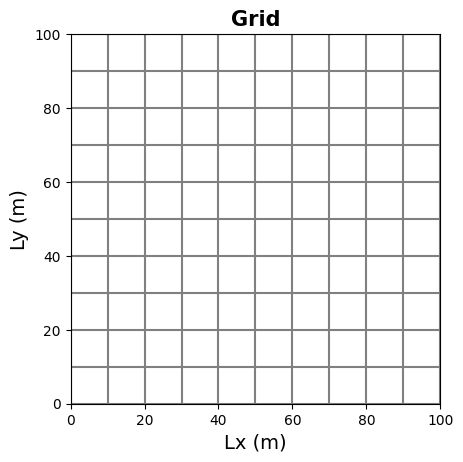

In [6]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

 <a name="III"></a> 
## III. MODFLOW BAS package

Next, we attach the BAS package to our model. The BAS package specifies cell activity (how cells will participate in the model run) as well as starting heads to be used in the cells at the start of the groundwater flow simulation.

### Define Cell Activity: IBOUND

We assign the cell activity using a variable called <strong>IBOUND</strong>. Ibound is defined as an array of integers of form (nlay, nrow, ncol), or one for each cell with flags for the activity level:

- <strong> >/= 1: active </strong> (cell has active finite difference equations calculating the head for this cell as well as flows between its neighbors) 
- <strong> = 0: inactive </strong> (cell has no active finite difference equations associated with it)
- <strong> </= 0: constant head </strong>  (cell has active finite difference equation for flows between cells but not for head at the cell as it is kept constant throughout the simulation)

For this model, the first and last column are set to be constant heads and the rest of the domain is set as active. 

In [7]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
#assign left and right boundary cells to constant head
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1

print("ibound values: \n", ibound)

ibound values: 
 [[[-1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1 -1]
  [-1  1  1  1  1  1  1  1  1 -1]]]


### Define Starting Heads

Values for starting heads are given cell by cell with the variable <strong>strt</strong> defined as an array of floats of form (nlay, nrow, ncol). For this model the left and right boundaries are set to be constant heads in the IBOUND variable, so the starting heads assigned to these cells will be set throughout the model. Since we are interested in steady-state flow from a left boundary of h=10m and right boundary of h=0m we assign those conditions in the strt variable.

In [8]:
#create strt as array of floats = 1
strt = 5*np.ones((nlay, nrow, ncol), dtype=np.float32)
#set left side head to 10 m
strt[:, :, 0] = 10.
#set right side head to 0 m
strt[:, :, -1] = 0.

print("starting head values: \n", strt)

starting head values: 
 [[[10.  5.  5.  5.  5.  5.  5.  5.  5.  0.]
  [10.  5.  5.  5.  5.  5.  5.  5.  5.  0.]
  [10.  5.  5.  5.  5.  5.  5.  5.  5.  0.]
  [10.  5.  5.  5.  5.  5.  5.  5.  5.  0.]
  [10.  5.  5.  5.  5.  5.  5.  5.  5.  0.]
  [10.  5.  5.  5.  5.  5.  5.  5.  5.  0.]
  [10.  5.  5.  5.  5.  5.  5.  5.  5.  0.]
  [10.  5.  5.  5.  5.  5.  5.  5.  5.  0.]
  [10.  5.  5.  5.  5.  5.  5.  5.  5.  0.]
  [10.  5.  5.  5.  5.  5.  5.  5.  5.  0.]]]


### Create BAS object

We now use <strong>strt</strong> and <strong>IBOUND</strong> to make the 'bas' flopy object which will later be used to create the MODFLOW BAS package.

In [9]:
#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)

If you wish to visualize the ibound variable assigned to this bas package, flopy ModelMap may be also used to display ibound. 

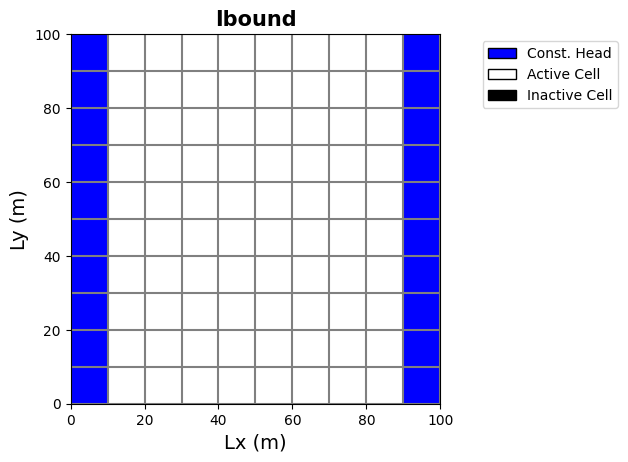

In [10]:
#plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

 <a name="IV"></a> 
## IV. MODFLOW LPF package

The LPF package specifies Layer Properties associated with the flow in each cell. It holds information regarding horizontal and vertical hydraulic conductivity, layer confinement properties (confined/unconfined), specific storage, and specific yield among other flags for the model run for  which we will use flopy's default settings.

### Define Hydraulic Conductivity

Here we define "hk" as a variable for horizontal hydraulic conductivity of 1 m/d that will be the same in the x and y directions, and "vka" as a variable for vertical conductivity of 1 m/d. hk and vka are arrays of floats of form (nlay, nrow, ncol) with conductivity values for each cell. You may also a ratio of anisotropy in the y direction for the flopy LPF function, if hk should be anisotropic in the xy plane. http://modflowpy.github.io/flopydoc/mflpf.html has details regarding these options.


In [11]:
#define horizontal hydraulic conductivity
hk = np.ones((nlay,nrow,ncol), dtype=np.float32)*5
vk = np.ones((nlay,nrow,ncol), dtype=np.float32)

print("horizontal k values: \n", hk,
     "\n vertical k values: \n", vk)

horizontal k values: 
 [[[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
  [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]]] 
 vertical k values: 
 [[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]]


### Define Aquifer Confinement Properties

Layers may be specified in flopy with variable <strong> laytyp </strong>, an array of (nlay) integer flags to say whether a model is:

- <strong> =0 Confined:</strong>  Aquifer layers will be treated as confined
- <strong> >0 Convertible:</strong> Aquifer layers will be treated as confined if the water level is above the top of the aquifer cell and unconfined if the water level is below the top of the aquifer cell.

This single-layer model will be treated as confined.

In [12]:
#define layer type as confined
laytyp = np.zeros((nlay,), dtype=np.int32)

print("layer type values: \n", laytyp)


layer type values: 
 [0]


### Define LPF object
We now use <strong>hk</strong>, <strong>vk</strong>, and <strong>laytyp</strong> to make the 'lpf' flopy object which will be used to create the MODFLOW LPF package. <strong>ipakcb</strong> is a flag to say whether we will save cell by cell budget data (flows etc) (ipakcb>0 = save data). (<strong>Note:</strong> Flopy claims that budget data saves by using the ipakcb default settings, but it seems that ipakcb must be explicitly specified in order to be saved.)

In [13]:
lpf = flopy.modflow.ModflowLpf(model=m, hk=hk, vka=vk, laytyp=laytyp, ipakcb=1)

 <a name="V"></a> 
## V. MODFLOW OC Package

The OC package tells MODFLOW which attributes of the head and flow solutions should be printed and saved for each stress period during the modelrun. 

### Create Output Control Stress Period Data 
To designate what data to save, we create variable <strong> spd </strong> as a  dictionary of stress period data to be used as an argument for the flopy oc function. This takes the form: 

spd = {(stress period, time step): ['PRINT HEAD', 'PRINT BUDGET', 'SAVE HEAD', 'SAVE DRAWDOWN', 'SAVE IBOUND', 'SAVE BUDGET']} 

<strong> Note </strong> that the list of strings may be modified if you wish to only save some of the data. Here we will choose to record and save budget and head values for our steady-state model with a single stress period/time step as we specified in the 'dis' object.

In [14]:
#create oc stress period data. 
spd = {(0, 0): ['save head', 'save budget']}

print("oc stress period data: \n", spd)

oc stress period data: 
 {(0, 0): ['save head', 'save budget']}


### Define OC object
We will use <strong>spd</strong> to make the 'oc' flopy object which will later be used to create the MODFLOW OC package.

In [15]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

 <a name="VI"></a> 
## VI. MODFLOW PCG Package

Attaching the PCG Package to a MODFLOW model, tells MODFLOW to use the Preconditioned Conjugate Gradient Package to solve the finite difference equation. Seeing as this model is steady-state in a very simple domain, the PCG package should have little trouble solving the groundwater flow equation with its default settings. However, MODFLOW has numerous other solver packages (Newton-Raphson (NWT), Direct Solver (DE4), Strongly Implicit Procedure (SIP), etc) that may be applicable to other models. Additionally, you may want to tweak the solving criterion depending on your model. If you are interested in the nitty gritty of these methods, the MODFLOW-2005 manual is a good resource: https://pubs.usgs.gov/tm/2005/tm6A16/PDF/TM6A16.pdf. 

Additionally, MODFLOW online describes these solvers: https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?oc.htm

And Flopy documents its communication with the PCG MODFLOW package:
http://modflowpy.github.io/flopydoc/mfpcg.html


### Define PCG Object

Here we will create the flopy pcg object, with its default solver settings, which will be used to create the MODFLOW PCG package.

In [16]:
pcg = flopy.modflow.ModflowPcg(model=m)

 <a name="VII"></a> 
## VII. Write MODFLOW Input Files

Now that we have created all the FloPy objects for the packages we wish to attach to our model (dis, bas, lpf, oc, and pcg), we can use FloPy to write the MODFLOW input files for our MODFLOW executable to read. This is done simply with:

In [17]:
#write MODFLOW input files
m.write_input()

FloPy should have created 6 new files in your working directory that look something like:

<img src="https://i.imgur.com/AjODHeO.png" title="modflow_files" /></a>

The file to pay attention to is the "my_model.nam" file. This file governs which packages will be attached to your MODFLOW file. Inside the name file it will list all the packages to be attached to your model as well as specify that BINARY DATA files that it will write as an output. (my_model.hds, my_model.cbc)

<img src="https://i.imgur.com/8KOHV9T.png" title="nam_file" /></a>

Another file to pay attention to, post run, is the LIST file. This will have additional information on how the packages are attached to your model as well as MODFLOW mass-balance budgets during the model run. 

 <a name="VIII"></a> 
## VIII. Run MODFLOW Model

We can now run the MODFLOW model with the packages specified in the .nam file using the executable specified in the definition of our flopy model 'm':

In [18]:
# Run the model
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: simple_modflow_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/10/28 21:10:37

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/10/28 21:10:37
 Elapsed run time:  0.128 Seconds

  Normal termination of simulation


If the run was successful, you should have seen a window reporting the run time data. 

 <a name="IX"></a> 
## IX. Read Head/Flow Data

We will now make use of FloPy's binary file reader and plotting capabilities to read and display the model output.

### Read Head Data

Head data from the my_model.hds file will be stored as a FloPy head object.

In [19]:
#extract binary data from head file as flopy head object
headobj = flopy.utils.binaryfile.HeadFile(f'{model_ws}/{modelname}.hds')

print("flopy head object: \n", headobj)

flopy head object: 


This head object has different attributes that can be extracted from it such as the times used in the model run, head data, databytes and more. For information on how to access these functions see: http://modflowpy.github.io/flopydoc/binaryfile.html

For this model, we will extract the head data after our single stress period (totim=1.0).

In [20]:
#extract head data from head object
head = headobj.get_data(totim=1.0)

In [21]:
head

array([[[10.       ,  8.888889 ,  7.7777777,  6.6666665,  5.5555553,
          4.4444447,  3.3333333,  2.2222223,  1.1111112,  0.       ],
        [10.       ,  8.888889 ,  7.7777777,  6.6666665,  5.5555553,
          4.4444447,  3.3333333,  2.2222223,  1.1111112,  0.       ],
        [10.       ,  8.888889 ,  7.7777777,  6.6666665,  5.5555553,
          4.4444447,  3.3333333,  2.2222223,  1.1111112,  0.       ],
        [10.       ,  8.888889 ,  7.7777777,  6.6666665,  5.5555553,
          4.4444447,  3.3333333,  2.2222223,  1.111111 ,  0.       ],
        [10.       ,  8.888889 ,  7.7777777,  6.6666665,  5.5555553,
          4.4444447,  3.3333333,  2.2222223,  1.111111 ,  0.       ],
        [10.       ,  8.888889 ,  7.7777777,  6.6666665,  5.5555553,
          4.4444447,  3.3333333,  2.2222223,  1.1111112,  0.       ],
        [10.       ,  8.888889 ,  7.7777777,  6.6666665,  5.5555553,
          4.4444447,  3.3333333,  2.2222223,  1.1111112,  0.       ],
        [10.       ,  8.888

### Read Flow Data

FloPy's binary budget data reader will be used to read in the budget data from my_model.cbc as a flopy budget object. (See: http://modflowpy.github.io/flopydoc/binaryfile.html#flopy.utils.binaryfile.CellBudgetFile for more info)

In [22]:
#extract binary data from budget file as flopy budget object
budgobj = flopy.utils.binaryfile.CellBudgetFile(f'{model_ws}/{modelname}.cbc')

print("flopy budget object: \n", budgobj)

flopy budget object: 


We can now extract the data from this by passing a string in the CellBudgetFile function's "text" argument to call which part of the data we want to get. Here we will access the flow data for the right face  and front face of each grid cell and save the data as variables 'frf' and 'fff' which are output as arrays.

In [23]:
frf = budgobj.get_data(text='flow right face', totim=1.0)
fff = budgobj.get_data(text='flow front face', totim=1.0)

print("Flow through Right Face of Grid Cells m^3/d \n", frf,
     "\n Flow through Front Face of Grid Cells m^3/d \n", fff)

Flow through Right Face of Grid Cells m^3/d 
 [array([[[277.77777, 277.7778 , 277.7778 , 277.7778 , 277.7778 ,
         277.7778 , 277.7778 , 277.7778 , 277.7778 ,   0.     ],
        [277.7778 , 277.7778 , 277.7778 , 277.7778 , 277.7778 ,
         277.7778 , 277.7778 , 277.7778 , 277.7778 ,   0.     ],
        [277.7778 , 277.7778 , 277.7778 , 277.7778 , 277.7778 ,
         277.7778 , 277.7778 , 277.7778 , 277.7778 ,   0.     ],
        [277.7778 , 277.7778 , 277.7778 , 277.7778 , 277.7778 ,
         277.7778 , 277.7778 , 277.7778 , 277.77777,   0.     ],
        [277.77777, 277.7778 , 277.7778 , 277.7778 , 277.7778 ,
         277.7778 , 277.7778 , 277.7778 , 277.77777,   0.     ],
        [277.7778 , 277.7778 , 277.7778 , 277.7778 , 277.7778 ,
         277.7778 , 277.7778 , 277.7778 , 277.7778 ,   0.     ],
        [277.77777, 277.7778 , 277.7778 , 277.7778 , 277.7778 ,
         277.7778 , 277.7778 , 277.7778 , 277.7778 ,   0.     ],
        [277.7778 , 277.7778 , 277.7778 , 277.7778

Here, it is good to check if results seem reasonable; for this steady-state model, it makes sense that  we see a constant value in the "Flow Right Face" output array as the higher head on the left side of the model induces flow from left to right. The "Flow Front Face" array, has very small positive and negative values in it, suggesting that there are potential numerical oscillations in our solution. However, these fluctuations are so small that the output may still be appropriate depending on the application/precision we are looking for. 

 <a name="X"></a> 
## X. Plotting

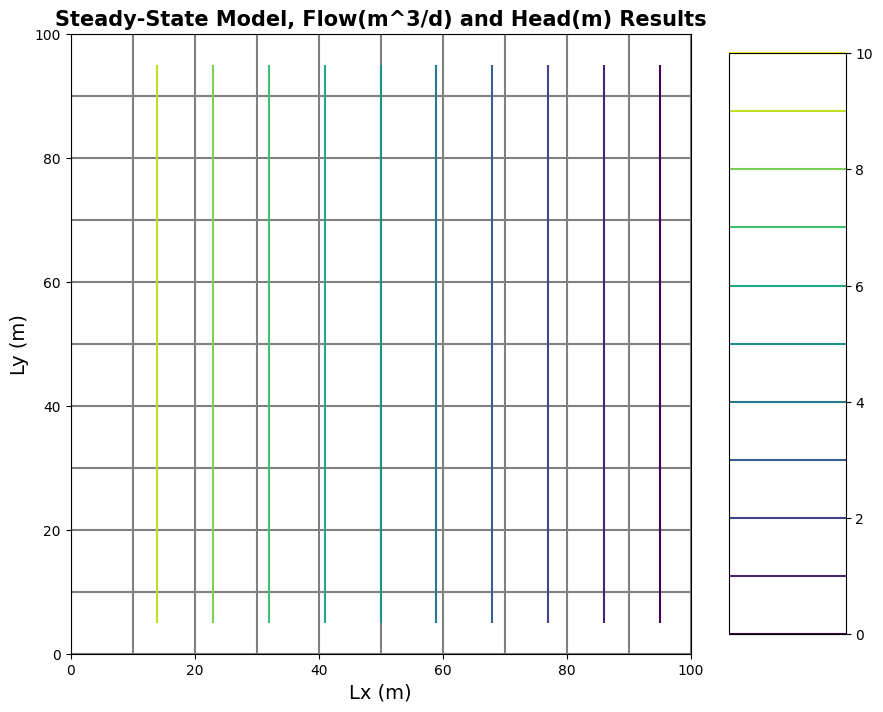

In [24]:
#plot results
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
grid = modelmap.plot_grid() #plot model grid
contour_levels = np.linspace(head[0].min(),head[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Model, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
plt.show(modelmap)

### 3D Surface Plot 

<strong> Note: </strong> This is not part of flopy's plotting, and uses a matplotlib function from a 3d projection toolkit. Flopy takes cell indexing where the top left of the grid is the (0,0) cell index while the Length & Width units start at 0 in the lower left of the grid. This seems a little wierd, but it makes it easy to match up an array of cell by cell numbers to their respective locations on the grid when assigning properties or observing output data. Flopy's plotting functions automatically flip the resultant head data to display on its proper grid, however, for the 3d plots below, you'll see the function np.flipud() is used to flip the data array to plot in the same direction.

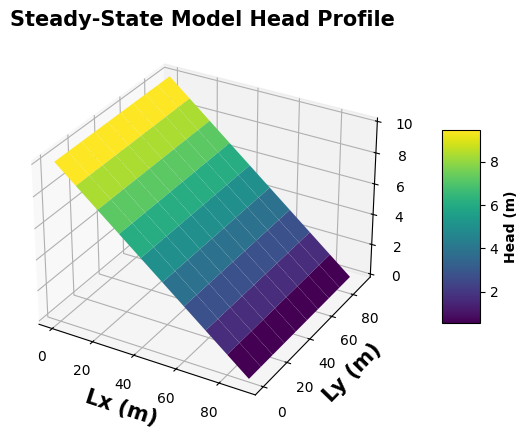

In [25]:
#import 3d axes toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

#create 3d figure
fig_3d, ax = plt.subplots(1, 1, figsize=(12,5), subplot_kw={"projection": "3d"})

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
plt.show(surf)

Congratulations! You just used FloPy to run a single-layer, steady-state model in MODFLOW-2005! 

<strong>Next steps:</strong> In the next notebook we will explore loading in the model inputs that we created here, essentially recreating this model from the MODFLOW input files we wrote. Then we will explore modifying the model inputs to see how the model responds to different aquifer properties.

What happens if you add another row of constant head cells to the model by modifying the IBOUND variable and set those to a different value of starting heads?